In [1]:
%clear all variables
clear all;

%reset the RNG to default
rng('default');

%start parallel processing
parpool

Starting parallel pool (parpool) using the 'local' profile ... connected to 4 workers.

ans = 

 Pool with properties: 

            Connected: true
           NumWorkers: 4
              Cluster: local
        AttachedFiles: {}
          IdleTimeout: 30 minute(s) (30 minutes remaining)
          SpmdEnabled: true



# Problem 1: FMINUNC - The Problem of Local Optima

Numerically minimize the function $\sin(x) + 0.01 (x − a)^{2}$ , setting a = 0, using Matlab's fminunc.

First, create an anonymous function handle:

In [6]:
%set the constant, a:
a=0;

In [7]:
%set the anonymous function to maximize
f = @(x) sin(x)+0.01*(x-a).^2;

Plot the function over the interval $\left(-5\pi, 5\pi \right)$.

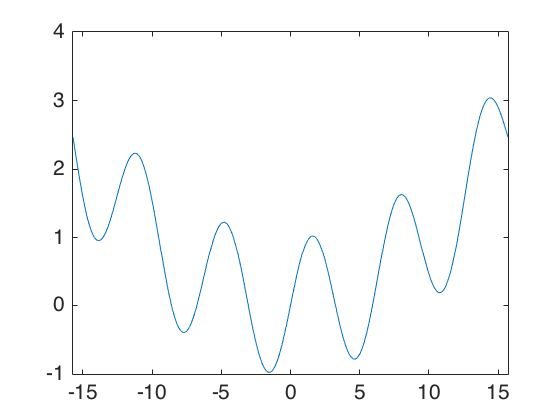

In [8]:
fplot(f,[-5*pi,5*pi]);

The above function has many local minima. The challenge will be finding the global minima (which seems to be between -5 and 0. 

Let's start to set the maximization routine by setting up the options that we will need (the alogrithm we want to use, the starting value, etc.). 

First, we will use the algorithm 'quasi-Newton' method. Then, we will provide the gradient (since this is an analytic problem) to use a better alogrithm (I will make use of python's symbolic computer algebra system to find the gradient - the first direvative. 

In [5]:
%set the options
%1. The algorithm will be quasi-newton (this is because the 
%   default algorithm, 'trust-region', requires the user to
%   input the gradient of the function as a second function),
%2. We will turn the display off (so we don't have a bunch of
%   crap on the screen).
%3. We will ask that the hessian use the 'bfsg' algorithm to 
%   update the search pattern.

options = optimoptions(@fminunc,'Algorithm','quasi-newton',...
                       'Display','off','HessUpdate','bfgs');

In [6]:
%set the starting value for guessing (a random integer between
%-20 and 20. 
x0 = 2.5;

%write the optimization routine
[min_val,f_val] = fminunc(f,x0,options)


min_val =

    4.6199


f_val =

   -0.7823


(a) and (b): The above code finds the minimum, however it is dependent on the starting value. Different starting values outside the domain $x\in [-4.8,1.6]$ produce local minimas. Because in the above our starting value was outside this domain, we obtain a local minima

## Finding the gradient and hessian with Symbolic Python

Let's find the gradient (in our case, with only one variable, the first direvative) so that we may see if this removes sensitivity. We'll use Python's sympy to do symbolic mathematics (we use cell magic '%%python' to switch us to python for just these cells). We will provide these as additional functions as practice to learn how to provide these to an optimization routine if they are needed. 

In [5]:
%%python

#Import sympy
from sympy import *

In [2]:
%%python

#declare symbols
x,a = symbols('x a')

#differentiate our objective function
print diff(sin(x)+0.01*(x-a)**2,x)

-0.02*a + 0.02*x + cos(x)


In [3]:
%%python

#differentiate again for hessian
print diff(sin(x)+0.01*(x-a)**2,x,2)

-sin(x) + 0.02


We will now program the gradient to provide it to fminunc. We will add them to the anonymous function to do this directly. 

In [10]:
%program the gradient and hessian as anon functions
%we use the deal method to have it deal out the 
%different functions

f_grad_hess = @(x) deal(sin(x)+0.01*(x-a).^2,...
                        -0.02*a + 0.02*x + cos(x),...
                        -sin(x) + 0.02);

In [11]:
%create a new options to tell matlab we will supply gradient
options_2 = optimoptions('fminunc','Algorithm','trust-region',...
                         'GradObj','on','Hessian','on',...
                         'Display','off');

In [12]:
%write the new minimization routine

[min_val_2,f_val_2] = fminunc(f_grad_hess,x0,options_2)

min_val_2 =

    4.6199


f_val_2 =

   -0.7823


# Problem 1: Use Multistart or Simulated Annealing for Global Optimization

Providing the gradient and the hessian does not help us here. It has no impact. Perhaps we can create a global optimization search in matlab to help find the minimum regardless of the starting value?

Because we are using 'fminunc' we will have to use Multistart. We can also parallelize Multistart in case the objective function happens to create slow computation. Multistart will use the otimization toolbox methods to tell matlab to: 1) create a problem using the desired solver and the input parameters of the problem; 2) declare that we are going to use a multistart (and optionally, if we want to run in parallel); 3) run the multistart problem on as many local solvers as we wish (it will automatically generate a vector of starting points at what are known as 'basins of attraction', or "areas" in the function that have steep descent/acent and thus where an optima may exist). The solvers are distributed on the cores of your computer. 

So basically, for part (c) of the problem this (along with the next section) is a strategy to use. For any $a\in(-\pi,\pi)$ we can find global minima with this algorithm of distributed starting values. 

In [13]:
%number of solvers:
n_solvers=50;

In [14]:
%Since we have already defined the problems previously, lets recycle
%(we could use the original f function that had matlab compute approx.
%hessians and numeric gradients, but since we have easy analytical 
%solutions we can just use the f_grad_hess all the same).

%with the original problem in the first cells above, define problem
problem = createOptimProblem('fminunc','objective',f_grad_hess,...
                             'x0',x0,'options', options_2);
                             
ms = MultiStart('UseParallel', true);

In [15]:
%write the MultiStart routine on 50 points

[min_val_3,f_val_3] = run(ms,problem,n_solvers)

MultiStart completed the runs from all start points.

All 50 local solver runs converged with a positive local solver exit flag.

min_val_3 =

   -1.5400


f_val_3 =

   -0.9758


The algorithm converged on the global optima. 

## Use Simulated Annealing to Globally Optimize

Here we will use simulated annealing, a method to globally optimize that does not require derivatives to conduct its optimization routine. So we will use the function $f$ we defined in the first part of the problem with no gradient or hessian.

In [16]:
%Let's set the options for simulated annealing, we want display off
options_3 = saoptimset('Display','off');

In [17]:
%Write the maximization routine

%we will reuse the initial starting point from the Multistart
%problem, no need to create a new one.

[min_val_4,f_val_4] = simulannealbnd(f,x0,[],[],options_3)

min_val_4 =

   -1.5401


f_val_4 =

   -0.9758


We see here that the algorithm also is able to converge to the global optima.

# Problem 2: FMINCON

We will resolve the problem with the constraint that $x\in[0,3]$ using fmincon. We can either supply the gradient and the hessian or we can leave it out (that is, we can choose to use the f function or the f_grad_hess function that contains the gradient and the hessian). The default algorithm does not use user-supplied gradients. 

In [18]:
%set the options for fmincon, where we provide
%user-supplied gradients and hessians:

options_4 = optimoptions('fmincon','Algorithm','trust-region-reflective',...
                         'GradObj','on','Hessian','on','Display','off',...
                         'UseParallel',true);

In [19]:
%the upper and lower bounds:
xlb = 0;
xub = 3;

%write the constrained minimization routine:

[min_val_5,f_val_5] = fmincon(f_grad_hess,x0,[],[],...
                              [],[],xlb,xub,[],options_4)

min_val_5 =

    3.0000


f_val_5 =

    0.2311


The above minimization is likewise sensitive to starting values because both of the boundries, 0 and 3, are local minima. This can be seen in the graph, as there is a local maxima in $x\in[0,3]$ that creates differente basins of attraction. We know that the true answer is 0. So we can also implement the global search routine to obtain this minima. 

# Problem 2: Using Mutistart or Simulated Annealing for Global Optimization

We can also use MultiStart to solve for the global optima of our constraint problem. Because we are using FMINCON, we can use matlab's GlobalSearch problem instead of MultiSearch (however, if we want to parallelize the problem across our computer's cores we would have to use MultiStart).

In [20]:
%Since we have already defined the problems previously, lets recycle
%We will use the associated optimization options and the objective
%function (with the programmed hessian and gradient) from f_grad_hess
%(we could also use f, but would need to adjust options to turn off
%the user-supplied gradients and hessian).

%with the original problem in the first cells above, define problem
problem_2 = createOptimProblem('fmincon','objective',f_grad_hess,...
                               'x0',x0,'lb',xlb,'ub',xub,...
                               'options', options_4);
                             
ms_2 = MultiStart('UseParallel', true);

In [21]:
%write the MultiStart routine on 100 points

[min_val_6,f_val_6] = run(ms_2,problem_2,n_solvers)

MultiStart completed the runs from all start points.

All 50 local solver runs converged with a positive local solver exit flag.

min_val_6 =

   7.0460e-12


f_val_6 =

   7.0460e-12


## Globally Constrained Optimization with Simulated Annealing

We can also use simulated annealing here with matlab. But ONLY because our constraints are bounds (S.A. in matlab currently only works with constraints that form upper and lower bounds; if we had linear euqality, inequality, or nonlinear constraints we would have to use FMINCON because S.A. does not allow for these types of constraints). 

In [22]:
%We can recycle code from problem 1 and the bounds already 
%defined. We will not need to create a new set of options either.
%Once again, we will use the function f we defined previously and
%not the function with the gradient and the hessian. We will also 

[min_val_7,f_val_7] = simulannealbnd(f,x0,xlb,xub,options_3)

min_val_7 =

   8.5550e-10


f_val_7 =

   8.5550e-10


# Problem 3: OLS minimization with FMINUNC

In [2]:
%Load the data
data = load('NerloveData.m');

%Remove the first column ('names' of firms):
data(:,1)=[];

%Sample Size (number of rows = number of samples)
N = size(data,1);

%Create the Y and X arrays (remember to take the logs):

%Y is column 1
Y = log(data(:,1));

%X matrix will be from data(:,2:end) and a constant
constant = ones(N,1);

X = [constant log(data(:,2:end))];

%Number of regressors:
K = size(X,2);

In [24]:
%Create the anonymous function that will be minimized:

SSR = @(beta) (Y - X*beta)'*(Y - X*beta);

In [25]:
%Create the initial value of the betas (we have 5). We
%will just start with a vecotr of 0s.

beta_0 = zeros(K,1);

In [26]:
%Create the minimization routine:
%we can use the same options we used for our function f 
%in problem 1 since we use the same routine.

[beta_hat,SSR_min] = fminunc(SSR,beta_0,options)

beta_hat =

   -3.5347
    0.7204
    0.4371
    0.4264
   -0.2184


SSR_min =

   21.5520


In [27]:
%Generate the epsilons and the SE of the betas
eps = Y-X*beta_hat;

%model variance:
var = eps'*eps/(N-K);

%the standard deviation of the model:
sigma_hat = sqrt(var)

%Variance-Covariance matrix of the beta parameters:
Var_Cov_beta = var*inv(X'*X);

%The standard errors of the betas:
SE_beta = sqrt(diag(Var_Cov_beta))

sigma_hat =

    0.3924


SE_beta =

    1.7744
    0.0175
    0.2910
    0.1004
    0.3394


In [2]:
%shut down parallel computing
delete(gcp('nocreate'))

Parallel pool using the 'local' profile is shutting down.
